In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.7.1+cpu False


In [2]:
!ls data/train/image | wc -l # 191961
!ls data/train/annos | wc -l # 191961
!ls data/test/test/image | wc -l # 62629

'ls' is not recognized as an internal or external command,
operable program or batch file.
'ls' is not recognized as an internal or external command,
operable program or batch file.
'ls' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
from PIL import Image
import numpy as np
import json

dataset = {
    "info": {},
    "licenses": [],
    "images": [],
    "annotations": [],
    "categories": []
}

lst_name = ['short_sleeved_shirt', 'long_sleeved_shirt', 'short_sleeved_outwear', 'long_sleeved_outwear',
            'vest', 'sling', 'shorts', 'trousers', 'skirt', 'short_sleeved_dress',
            'long_sleeved_dress', 'vest_dress', 'sling_dress']

for idx, e  in enumerate(lst_name):
    dataset['categories'].append({
        'id': idx + 1,
        'name': e,
        'supercategory': "clothes",
        'keypoints': ['%i' % (i) for i in range(1, 295)],
        'skeleton': []
    })

num_images = 191961 #32153
sub_index = 0  # the index of ground truth instance
for num in range(1, num_images + 1):
    if num % 1000 == 0:
        print(f"{num}/{num_images}")
    json_name = 'data/train/annos/' + str(num).zfill(6) + '.json'
    image_name = 'data/train/image/' + str(num).zfill(6) + '.jpg'

    if (num >= 0):
        imag = Image.open(image_name)
        width, height = imag.size
        with open(json_name, 'r') as f:
            temp = json.loads(f.read())
            pair_id = temp['pair_id']

            dataset['images'].append({
                'coco_url': '',
                'date_captured': '',
                'file_name': str(num).zfill(6) + '.jpg',
                'flickr_url': '',
                'id': num,
                'license': 0,
                'width': width,
                'height': height
            })
            for i in temp:
                if i == 'source' or i == 'pair_id':
                    continue
                else:
                    points = np.zeros(294 * 3)
                    sub_index = sub_index + 1
                    box = temp[i]['bounding_box']
                    w = box[2] - box[0]
                    h = box[3] - box[1]
                    x_1 = box[0]
                    y_1 = box[1]
                    bbox = [x_1, y_1, w, h]
                    cat = temp[i]['category_id']
                    style = temp[i]['style']
                    seg = temp[i]['segmentation']
                    landmarks = temp[i]['landmarks']

                    points_x = landmarks[0::3]
                    points_y = landmarks[1::3]
                    points_v = landmarks[2::3]
                    points_x = np.array(points_x)
                    points_y = np.array(points_y)
                    points_v = np.array(points_v)
                    case = [0, 25, 58, 89, 128, 143, 158, 168, 182, 190, 219, 256, 275, 294]
                    idx_i, idx_j = case[cat - 1], case[cat]

                    for n in range(idx_i, idx_j):
                        points[3 * n] = points_x[n - idx_i]
                        points[3 * n + 1] = points_y[n - idx_i]
                        points[3 * n + 2] = points_v[n - idx_i]

                    num_points = len(np.where(points_v > 0)[0])

                    dataset['annotations'].append({
                        'area': w * h,
                        'bbox': bbox,
                        'category_id': cat,
                        'id': sub_index,
                        'pair_id': pair_id,
                        'image_id': num,
                        'iscrowd': 0,
                        'style': style,
                        'num_keypoints': num_points,
                        'keypoints': points.tolist(),
                        'segmentation': seg,
                    })

json_name = 'data/train/deepfashion2_train.json'
with open(json_name, 'w') as f:
    json.dump(dataset, f)

1000/191961
2000/191961
3000/191961
4000/191961
5000/191961
6000/191961
7000/191961
8000/191961
9000/191961
10000/191961
11000/191961
12000/191961
13000/191961
14000/191961
15000/191961
16000/191961
17000/191961
18000/191961
19000/191961
20000/191961
21000/191961
22000/191961
23000/191961
24000/191961
25000/191961
26000/191961
27000/191961
28000/191961
29000/191961
30000/191961
31000/191961
32000/191961
33000/191961
34000/191961
35000/191961
36000/191961
37000/191961
38000/191961
39000/191961
40000/191961
41000/191961
42000/191961
43000/191961
44000/191961
45000/191961
46000/191961
47000/191961
48000/191961
49000/191961
50000/191961
51000/191961
52000/191961
53000/191961
54000/191961
55000/191961
56000/191961
57000/191961
58000/191961
59000/191961
60000/191961
61000/191961
62000/191961
63000/191961
64000/191961
65000/191961
66000/191961
67000/191961
68000/191961
69000/191961
70000/191961
71000/191961
72000/191961
73000/191961
74000/191961
75000/191961
76000/191961
77000/191961
78000/19

In [2]:
import cv2

In [3]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import os
import numpy as np
import random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("deepfashion_train", {}, "data/train/deepfashion2_train.json", "data/train/image")

In [5]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("deepfashion_train",)
cfg.DATASETS.TEST = ()
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13
cfg.MODEL.DEVICE = "cpu" # maybe if we train remotely we can change this...
cfg.TEST.EVAL_PERIOD = 500

In [9]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[01/02 11:02:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[01/02 11:05:18 d2.data.datasets.coco]: Loading data/train/deepfashion2_train.json takes 186.65 seconds.
[01/02 11:05:18 d2.data.datasets.coco]: Loaded 191961 images in COCO format from data/train/deepfashion2_train.json
[01/02 11:07:13 d2.data.build]: Removed 0 images with no usable annotations. 191961 images left.
[01/02 11:07:21 d2.data.build]: Distribution of instances among all 13 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
| short_sleev.. | 71645        | long_sleeve.. | 36064        | short_sleev.. | 543          |
| long_sleeve.. | 13457        |     vest      | 16095        |     sling     | 1985         |
|    shorts     | 36616        |   trousers    | 55387        |     skirt     | 30835        |
| short_sleev.. | 17211        | long_sleeve.. | 7907         |  vest_dress   | 17949        |
|  sling_dress  | 6492       

model_final_f6e8b1.pkl: 243MB [00:15, 15.8MB/s]                                                                        
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (14, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (14,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (52, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (52,) in the model! You might want to double check if this is expected.


[01/02 11:08:48 d2.engine.train_loop]: Starting training from iteration 0
ERROR [01/02 11:09:16 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "C:\Users\Matthew\anaconda3\lib\site-packages\detectron2\engine\train_loop.py", line 134, in train
    self.run_step()
  File "C:\Users\Matthew\anaconda3\lib\site-packages\detectron2\engine\defaults.py", line 429, in run_step
    self._trainer.run_step()
  File "C:\Users\Matthew\anaconda3\lib\site-packages\detectron2\engine\train_loop.py", line 222, in run_step
    data = next(self._data_loader_iter)
  File "C:\Users\Matthew\anaconda3\lib\site-packages\detectron2\data\common.py", line 179, in __iter__
    for d in self.dataset:
  File "C:\Users\Matthew\anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 352, in __iter__
    return self._get_iterator()
  File "C:\Users\Matthew\anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 294, in _get_iterator
    return _MultiProcessi

OSError: [Errno 22] Invalid argument

In [8]:
%load_ext tensorboard
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 4972), started 0:01:31 ago. (Use '!kill 4972' to kill it.)

In [32]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.27   # set the testing threshold for this model
cfg.DATASETS.TEST = ("deepfashion_train", )
predictor = DefaultPredictor(cfg)

In [35]:
from detectron2.utils.visualizer import ColorMode
im = cv2.imread("a.jpg")
outputs = predictor(im)

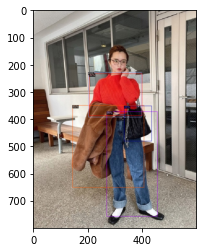

In [36]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2.imwrite('ok.png', v.get_image()[:, :, ::-1])
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()
